In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import gradio as gr

In [2]:
# Height and width refer to the size of the image
# Channels refers to the amount of color channels (red, green, blue)

image_dimensions = {'height':256, 'width':256, 'channels':3}

In [3]:
# Create a Classifier class

class Classifier:
    def __init__():
        self.model = 0
    
    def predict(self, x):
        return self.model.predict(x)
    
    def fit(self, x, y):
        return self.model.train_on_batch(x, y)
    
    def get_accuracy(self, x, y):
        return self.model.test_on_batch(x, y)
    
    def load(self, path):
        self.model.load_weights(path)

In [57]:
# Create a MesoNet class using the Classifier

class Meso4(Classifier):
    def __init__(self, learning_rate = 0.001):
        self.model = self.init_model()
        optimizer = Adam(lr = learning_rate)
        self.model.compile(optimizer = optimizer,
                           loss = 'mean_squared_error',
                           metrics = ['accuracy'])
    
    def init_model(self): 
        x = Input(shape = (image_dimensions['height'],
                           image_dimensions['width'],
                           image_dimensions['channels']))
        
        x1 = Conv2D(8, (3, 3), padding='same', activation = 'relu')(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
        
        x2 = Conv2D(8, (5, 5), padding='same', activation = 'relu')(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)
        
        x3 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
        
        x4 = Conv2D(16, (5, 5), padding='same', activation = 'relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)
        
        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation = 'sigmoid')(y)

        return Model(inputs = x, outputs = y)

In [58]:
# Instantiate a MesoNet model with pretrained weights
meso = Meso4()
meso.load('./weights/Meso4_DF')

In [59]:
# Prepare image data

# Rescaling pixel values (between 1 and 255) to a range between 0 and 1
dataGenerator = ImageDataGenerator(rescale=1./255)

# Instantiating generator to feed images through the network
generator = dataGenerator.flow_from_directory(
    './data/',
    target_size=(256, 256),
    batch_size=1,
    class_mode='binary')

Found 3248 images belonging to 2 classes.


In [60]:
# Checking class assignment
generator.class_indices

{'Real': 0, 'fake': 1}

In [61]:
# '.ipynb_checkpoints' is a *hidden* file Jupyter creates for autosaves
# It must be removed for flow_from_directory to work.
!rmdir /s /q c:data\.ipynb_checkpoints

# Equivalent command in Unix (for Mac / Linux users)
# !rm -r /Users/mikhaillenko/mesonet/mesonet/data/.ipynb_checkpoints/

The system cannot find the file specified.


In [62]:
# Recreating generator after removing '.ipynb_checkpoints'
dataGenerator = ImageDataGenerator(rescale=1./255)

generator = dataGenerator.flow_from_directory(
    './data/',
    target_size=(256, 256),
    batch_size=1,
    class_mode='binary')

# Re-checking class assignment after removing it
generator.class_indices

Found 3248 images belonging to 2 classes.


{'Real': 0, 'fake': 1}

1/1 [==============================] - 0s 180ms/step
Predicted likelihood: 0.5520
Actual label: 0
1/1 [==============================] - 0s 30ms/step

Correct prediction: False


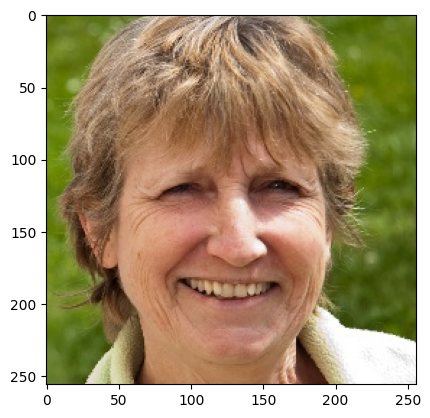

In [63]:
# Rendering image X with label y for MesoNet
X, y = generator.next()

# Evaluating prediction
print(f"Predicted likelihood: {meso.predict(X)[0][0]:.4f}")
print(f"Actual label: {int(y[0])}")
print(f"\nCorrect prediction: {round(meso.predict(X)[0][0])==y[0]}")

# Showing image
plt.imshow(np.squeeze(X));

In [64]:
# Creating separate lists for correctly classified and misclassified images
correct_real = []
correct_real_pred = []

correct_deepfake = []
correct_deepfake_pred = []

misclassified_real = []
misclassified_real_pred = []

misclassified_deepfake = []
misclassified_deepfake_pred = []

In [65]:
# Generating predictions on validation set, storing in separate lists
for i in range(len(generator.labels)):
    
    # Loading next picture, generating prediction
    X, y = generator.next()
    pred = meso.predict(X)[0][0]
    
    # Sorting into proper category
    if round(pred)==y[0] and y[0]==1:
        correct_real.append(X)
        correct_real_pred.append(pred)
    elif round(pred)==y[0] and y[0]==0:
        correct_deepfake.append(X)
        correct_deepfake_pred.append(pred)
    elif y[0]==1:
        misclassified_real.append(X)
        misclassified_real_pred.append(pred)
    else:
        misclassified_deepfake.append(X)
        misclassified_deepfake_pred.append(pred)   
        
    # Printing status update
    if i % 1000 == 0:
        print(i, ' predictions completed.')
    
    if i == len(generator.labels)-1:
        print("All", len(generator.labels), "predictions completed")

1/1 [==============================] - 0s 40ms/step
0  predictions completed.
1/1 [==============================] - 0s 29ms/step
1000  predictions completed.
1/1 [==============================] - 0s 21ms/step
2000  predictions completed.
1/1 [==============================] - 0s 33ms/step
3000  predictions completed.
1/1 [==============================] - 0s 26ms/step
All 3248 predictions completed


In [66]:
def plotter(images,preds):
    fig = plt.figure(figsize=(16,9))
    subset = np.random.randint(0, len(images)-1, 12)
    for i,j in enumerate(subset):
        fig.add_subplot(3,4,i+1)
        plt.imshow(np.squeeze(images[j]))
        plt.xlabel(f"Model confidence: \n{preds[j]:.4f}")
        plt.tight_layout()
        ax = plt.gca()
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])
    plt.show;
    return

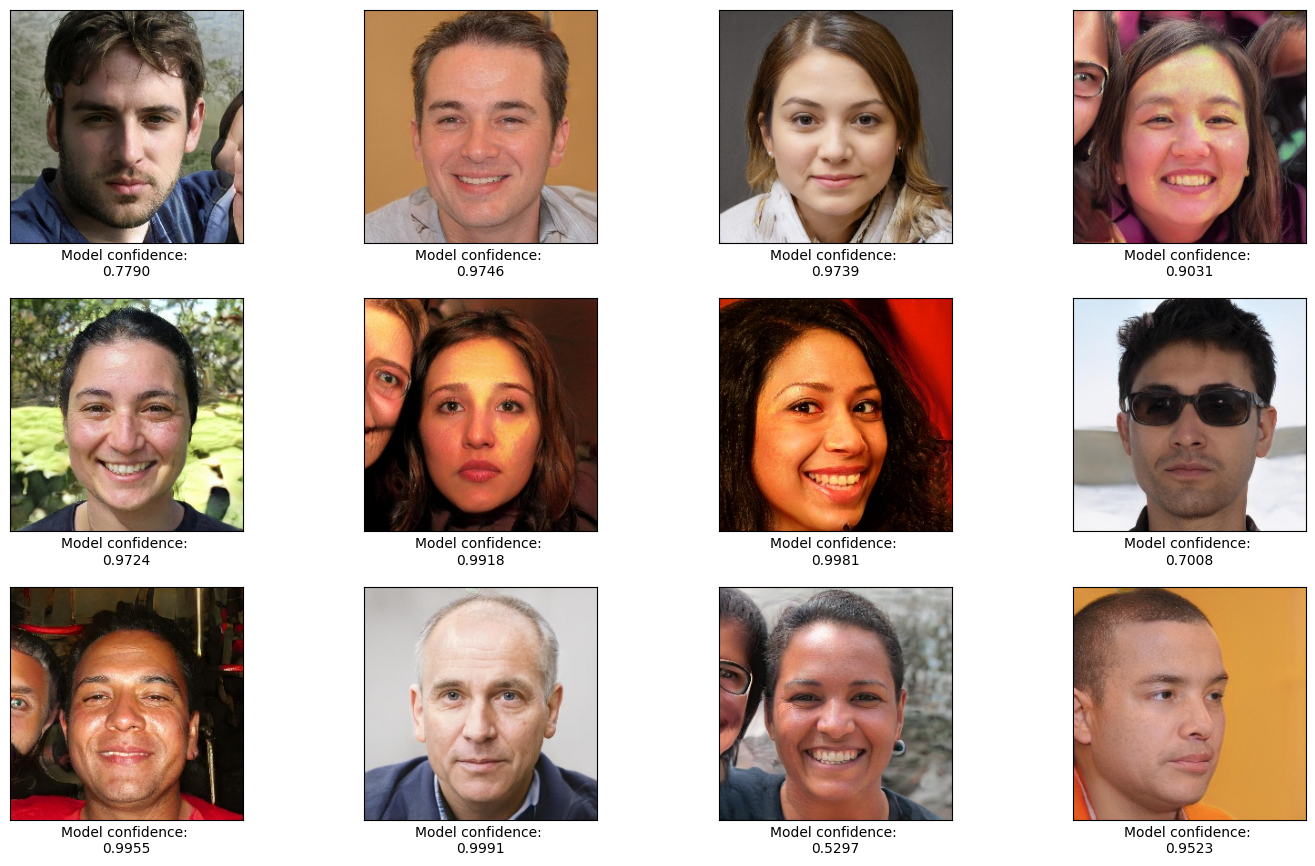

In [67]:
plotter(correct_real, correct_real_pred)

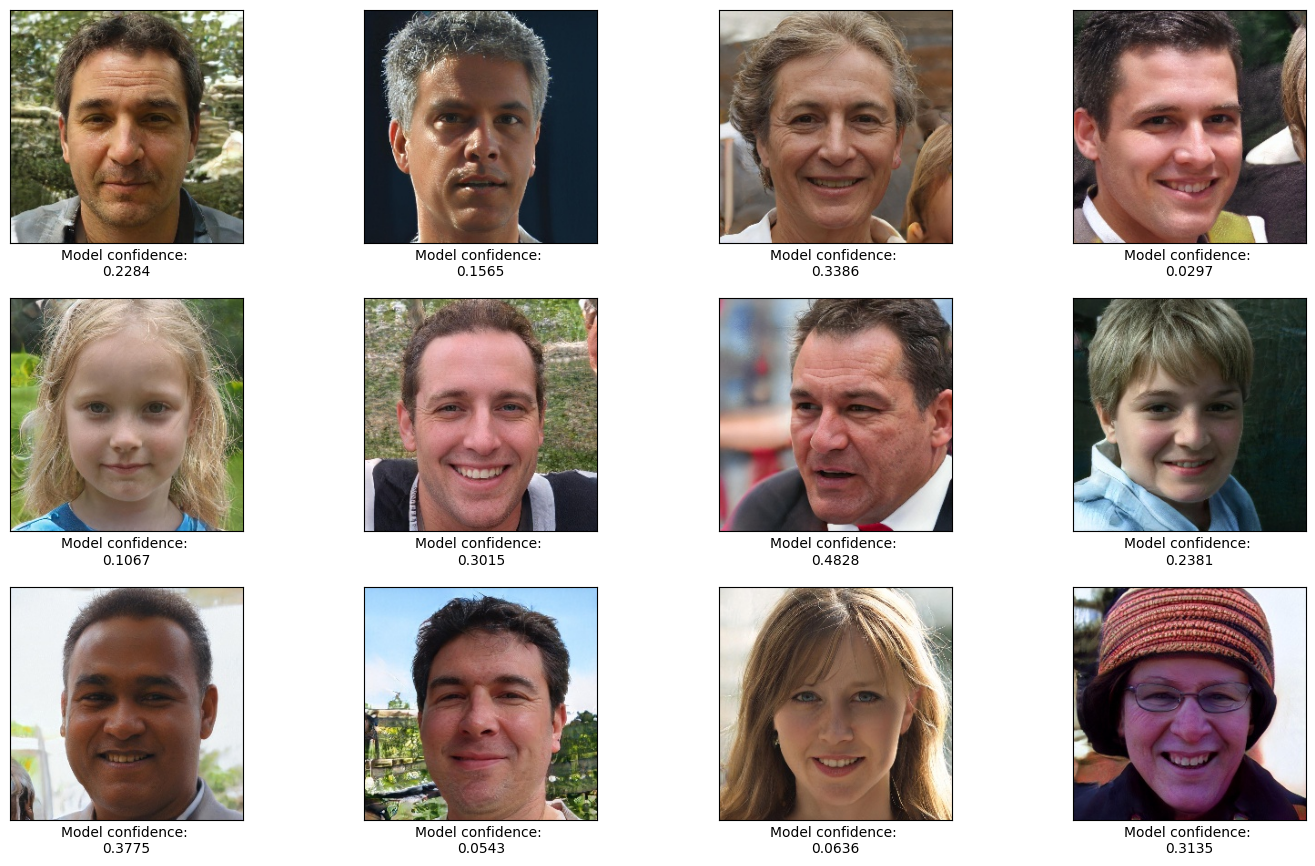

In [68]:
plotter(misclassified_real, misclassified_real_pred)

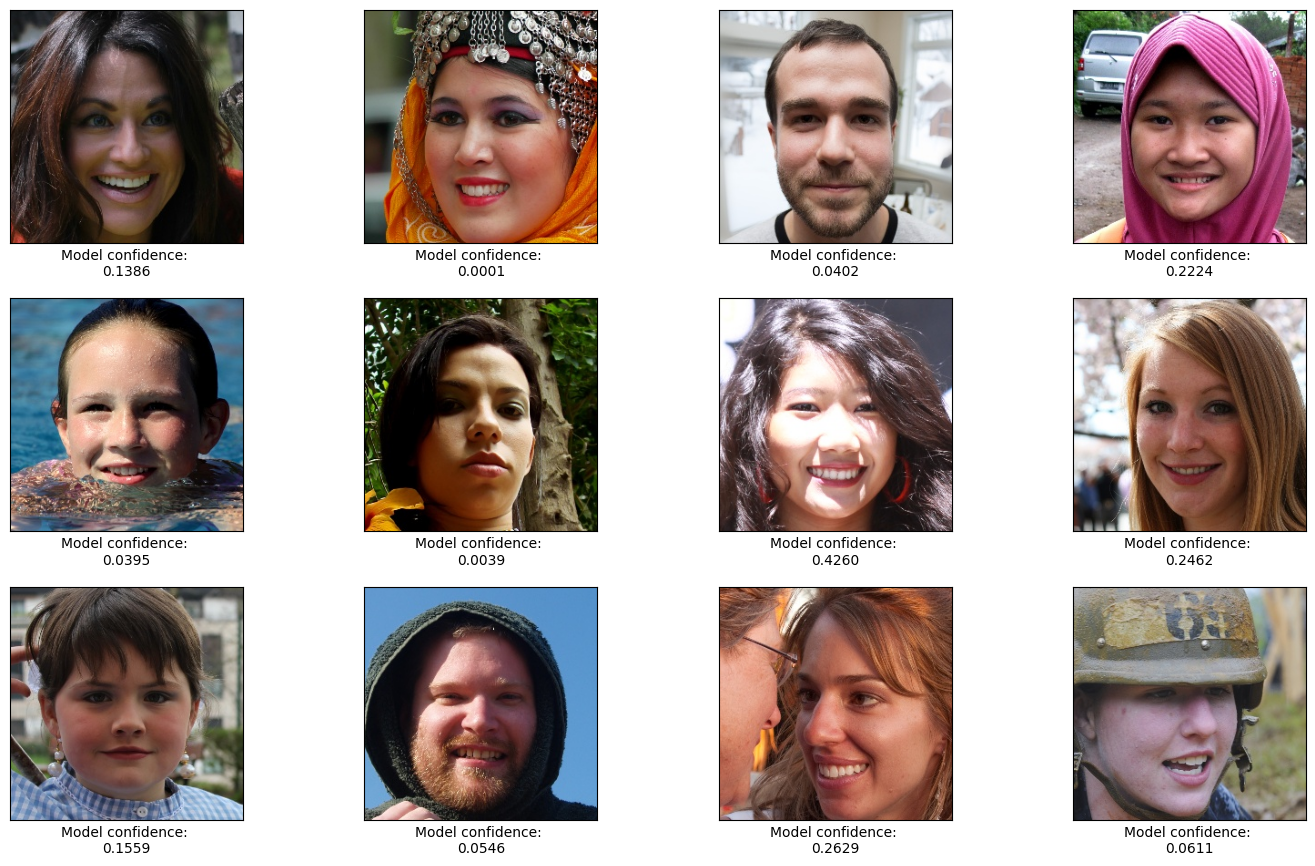

In [69]:
plotter(correct_deepfake, correct_deepfake_pred)

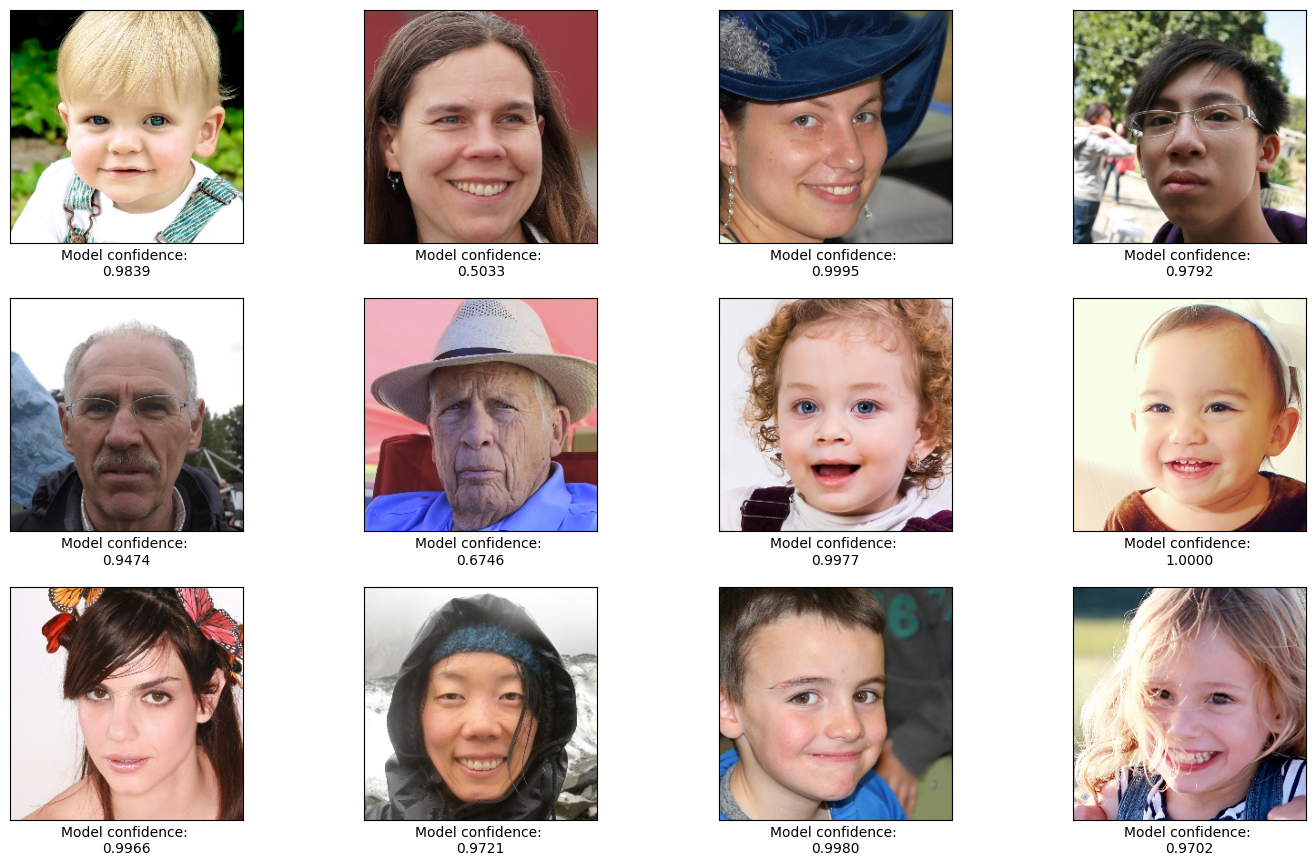

In [70]:
plotter(misclassified_deepfake, misclassified_deepfake_pred)

In [71]:
# def predict(input_image):
#     """Predict the label of the input_image"""
#     face = meso(input_image)
#     if face is None:
#         raise Exception('No face detected')
#     face = face.unsqueeze(0) # add the batch dimension
#     face = F.interpolate(face, size=(256, 256), mode='bilinear', align_corners=False)
    
#     # convert the face into a numpy array to be able to plot it
#     prev_face = face.squeeze(0).permute(1, 2, 0).cpu().detach().int().numpy()
#     prev_face = prev_face.astype('uint8')

#     face = face.to(DEVICE)
#     face = face.to(torch.float32)
#     face = face / 255.0
#     face_image_to_plot = face.squeeze(0).permute(1, 2, 0).cpu().detach().int().numpy()

#     target_layers=[model.block8.branch1[-1]]
#     use_cuda = True if torch.cuda.is_available() else False
#     cam = GradCAM(model=model, target_layers=target_layers, use_cuda=use_cuda)
#     targets = [ClassifierOutputTarget(0)]

#     grayscale_cam = cam(input_tensor=face, targets=targets, eigen_smooth=True)
#     grayscale_cam = grayscale_cam[0, :]
#     visualization = show_cam_on_image(face_image_to_plot, grayscale_cam, use_rgb=True)
#     face_with_mask = cv2.addWeighted(prev_face, 1, visualization, 0.5, 0)

#     with torch.no_grad():
#         output = torch.sigmoid(model(face).squeeze(0))
#         prediction = "real" if output.item() < 0.5 else "fake"
        
#         real_prediction = 1 - output.item()
#         fake_prediction = output.item()
        
#         confidences = {
#             'real': real_prediction,
#             'fake': fake_prediction
#         }
#     return confidences, face_with_mask


In [72]:
# interface = gr.Interface(
#     fn=predict,
#     inputs=[
#         gr.inputs.Image(label="Input Image", type="pil")
#     ],
#     outputs=[
#         gr.outputs.Label(label="Class"),
#         gr.outputs.Image(label="Face with Explainability", type="pil")
#     ],
# ).launch()

In [73]:
def predict_image(image):
    image = image.resize((image_dimensions['height'], image_dimensions['width']))
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    pred = meso.predict(image)[0][0]
    return {'Fake': float(pred), 'Real': float(1 - pred)}

# Define the Gradio interface
iface = gr.Interface(fn=predict_image, 
                     inputs=gr.inputs.Image(type="pil"),
                     outputs=gr.outputs.Label(num_top_classes=2))

# Launch the interface
iface.launch()


C:\Users\pande\AppData\Local\Temp\ipykernel_14964\1533308785.py:10: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  inputs=gr.inputs.Image(type="pil"),
C:\Users\pande\AppData\Local\Temp\ipykernel_14964\1533308785.py:10: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  inputs=gr.inputs.Image(type="pil"),
C:\Users\pande\AppData\Local\Temp\ipykernel_14964\1533308785.py:11: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  outputs=gr.outputs.Label(num_top_classes=2))
C:\Users\pande\AppData\Local\Temp\ipykernel_14964\1533308785.py:11: GradioUnusedKwargWarning: You have unused kwarg parameters in Label, please remove them: {'type': 'auto'}
  outputs=gr.outputs.Label(num_top_classes=2))


Running on local URL:  http://127.0.0.1:7866

To create a public link, set `share=True` in `launch()`.


IMPORTANT: You are using gradio version 3.43.1, however version 4.29.0 is available, please upgrade.
--------


1/1 [==============================] - 0s 43ms/step
0  predictions completed.
1/1 [==============================] - 0s 26ms/step
1000  predictions completed.
1/1 [==============================] - 0s 34ms/step
2000  predictions completed.
1/1 [==============================] - 0s 22ms/step
3000  predictions completed.
1/1 [==============================] - 0s 33ms/step
Model accuracy: 0.5194
1/1 [==============================] - 0s 25ms/step
Predicted likelihood: 0.9889
Actual label: 1
1/1 [==============================] - 0s 29ms/step
Correct prediction: True


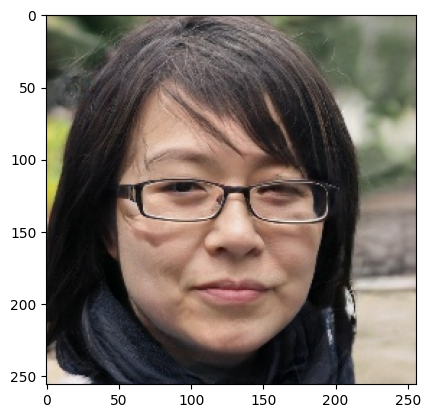

In [74]:
# Initialize counters
correct_predictions = 0
total_predictions = 0
# Loop through the images and make predictions
for i in range(len(generator.labels)):
    X, y = generator.next()
    pred = meso.predict(X)[0][0]
    total_predictions += 1
    if round(pred) == y[0]:
        correct_predictions += 1

    if i % 1000 == 0:
        print(i, ' predictions completed.')

# Calculate and print accuracy
accuracy = correct_predictions / total_predictions
print(f"Model accuracy: {accuracy:.4f}")

# Example: Print a sample prediction
X, y = generator.next()
print(f"Predicted likelihood: {meso.predict(X)[0][0]:.4f}")
print(f"Actual label: {int(y[0])}")
print(f"Correct prediction: {round(meso.predict(X)[0][0])==y[0]}")
plt.imshow(np.squeeze(X));
plt.show()